## Dataset Informtion
The objective of this task is to detect hate speech in tweets. For the sake of simpicty, we say a tweet cortains hate speech if it has a racist or sexist sentimert associated with it. So, the task is to classify racist or sexist tweets from other tweets.
Label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist.

## Import modules

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

## Loading the Dataset

In [3]:
# Read the file
adress = r'train_E6oV3lV.csv'
df = pd.read_csv(adress)

In [4]:
# First 5 rows
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
# Number of rows
df.shape

(31962, 3)

In [6]:
# Dataset info & check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


## Preprocessing the Dataset

### Remove twitter handels

In [7]:
def remove_pattern(text, pattern):
    r = re.findall(pattern, text)
    for word in r:
        text = re.sub(word, '', text)
    return text

In [8]:
df['clean_tweet'] = np.vectorize(remove_pattern)(df['tweet'], '@[\w]*')

### Remove special characters, numbers and punctuations

In [9]:
df['clean_tweet'] = df['clean_tweet'].str.replace('[^a-zA-Z#]', ' ')

### Romve short words

In [10]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

### Stemming

In [11]:
# Individual words considered as tokens
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())

In [15]:
# Stem the words
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(word) for word in x])

In [16]:
# Combine into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['clean_tweet'] = tokenized_tweet

## Explatory Data Analysis

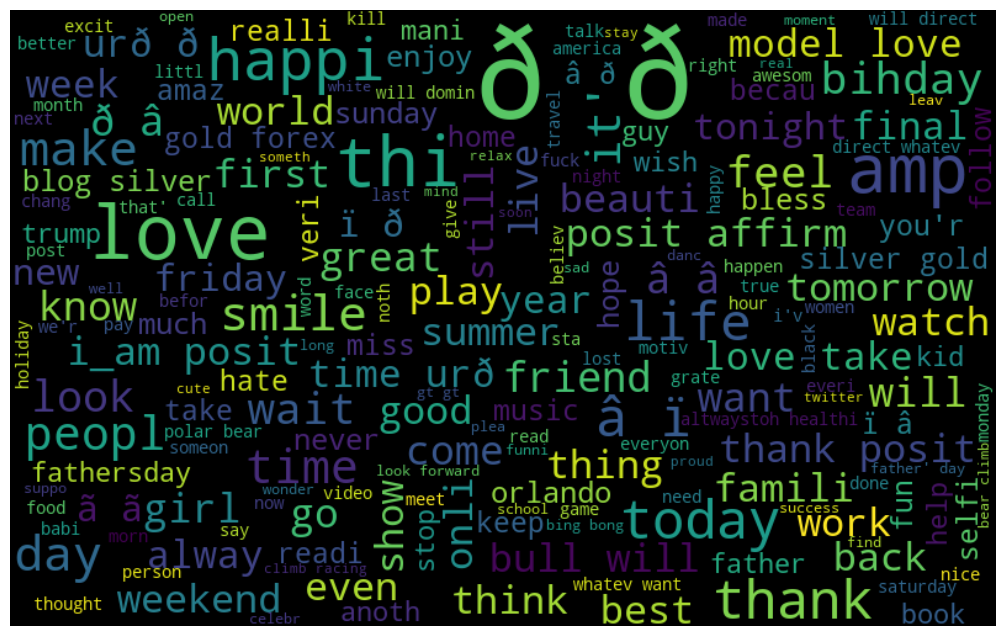

In [20]:
# Visualize the frequent words
all_words = ' '.join([sentence for sentence in df['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

# Plot the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

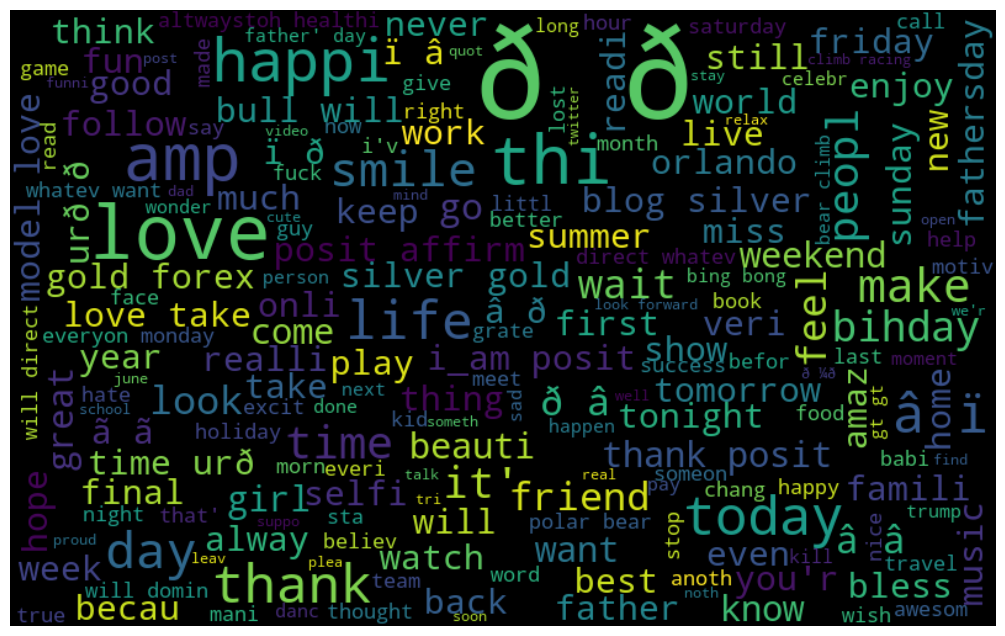

In [21]:
# Frequent words visulaization for positive
all_words = ' '.join([sentence for sentence in df['clean_tweet'][df['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

# Plot the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

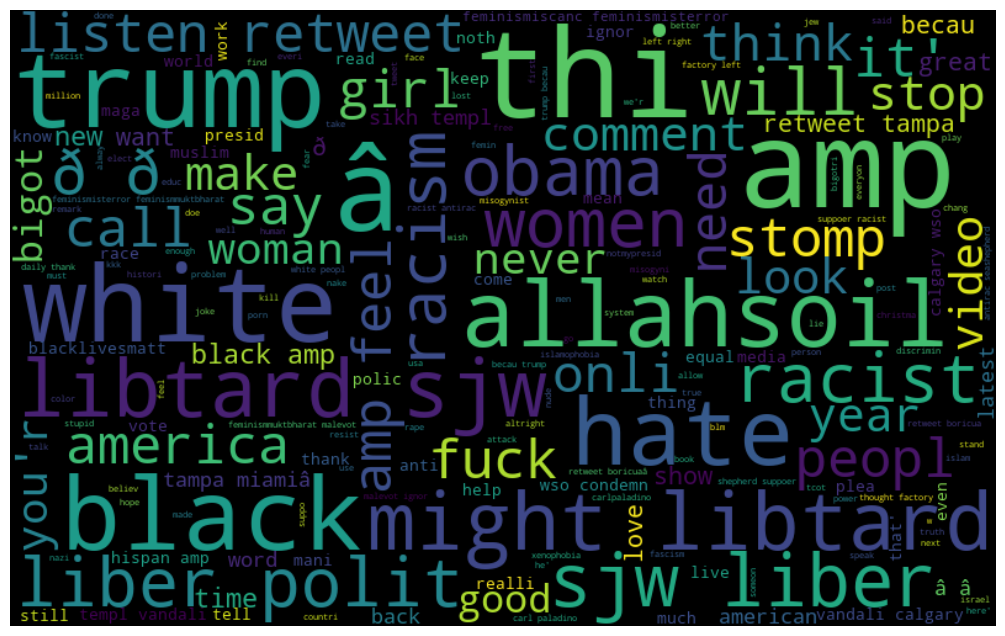

In [22]:
# Frequent words visulaization for negative
all_words = ' '.join([sentence for sentence in df['clean_tweet'][df['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

# Plot the graph
plt.figure(figsize = (15, 8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [27]:
# Extract the hashtag
def hashtag_extract(tweets):
    hashtags =[]
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r'#(\w+)', tweet)
        hashtags.append(ht)
    return hashtags

In [29]:
# Extract hashtags from non racist/sexist tweets
ht_positive = hashtag_extract(df['clean_tweet'][df['label'] == 0])

In [30]:
# Extract hashtags from racist/sexist tweets
ht_negative = hashtag_extract(df['clean_tweet'][df['label'] == 1])

In [31]:
ht_positive = sum(ht_psitive, [])
ht_negative = sum(ht_negative, [])

In [32]:
ht_positive[:5]

['run', 'lyft', 'disapoint', 'getthank', 'model']

In [33]:
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag':list(freq.keys()),
                 'Count': list(freq.values())})

In [34]:
d.head()

,Hashtag,Count
0,run,70
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,374


<Axes: xlabel='Hashtag', ylabel='Count'>

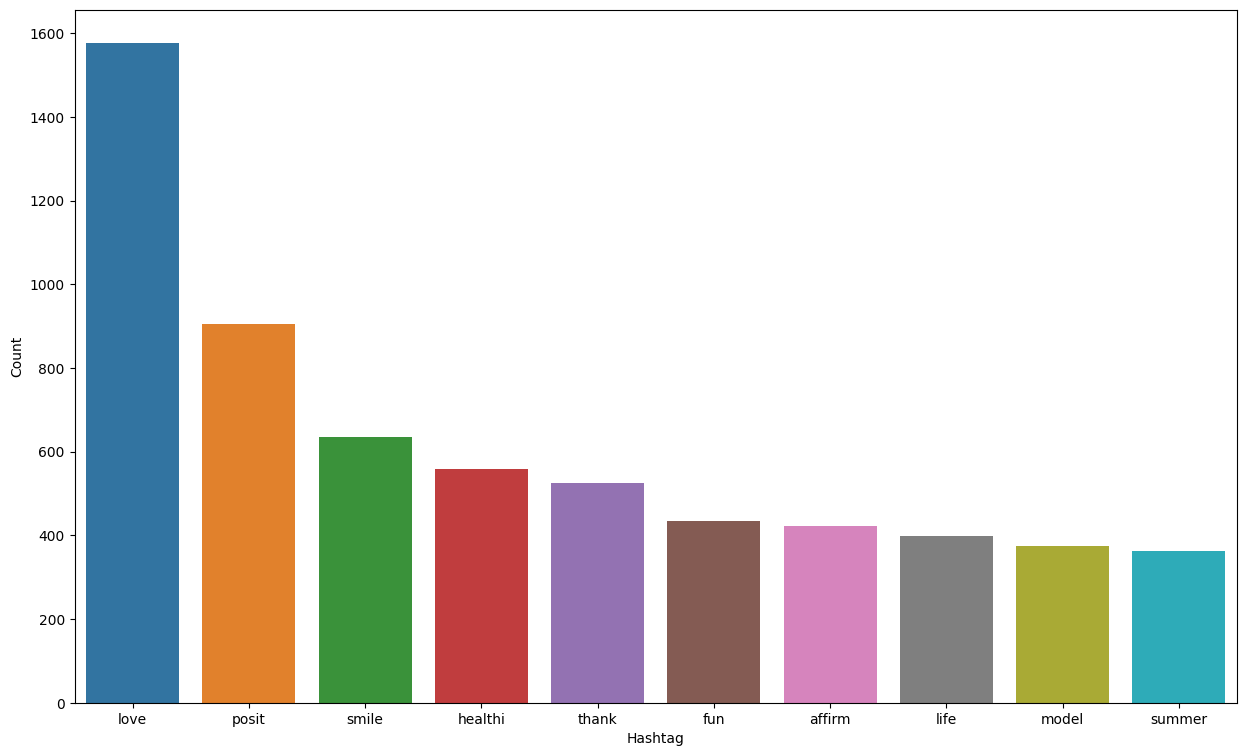

In [36]:
# Select top 10 hashtags
d = d.nlargest(columns = 'Count', n = 10)
plt.figure(figsize = (15,9))
sns.barplot(data = d, x = 'Hashtag', y = 'Count')

In [37]:
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag':list(freq.keys()),
                 'Count': list(freq.values())})

In [38]:
d.head()

,Hashtag,Count
0,cnn,9
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,2


<Axes: xlabel='Hashtag', ylabel='Count'>

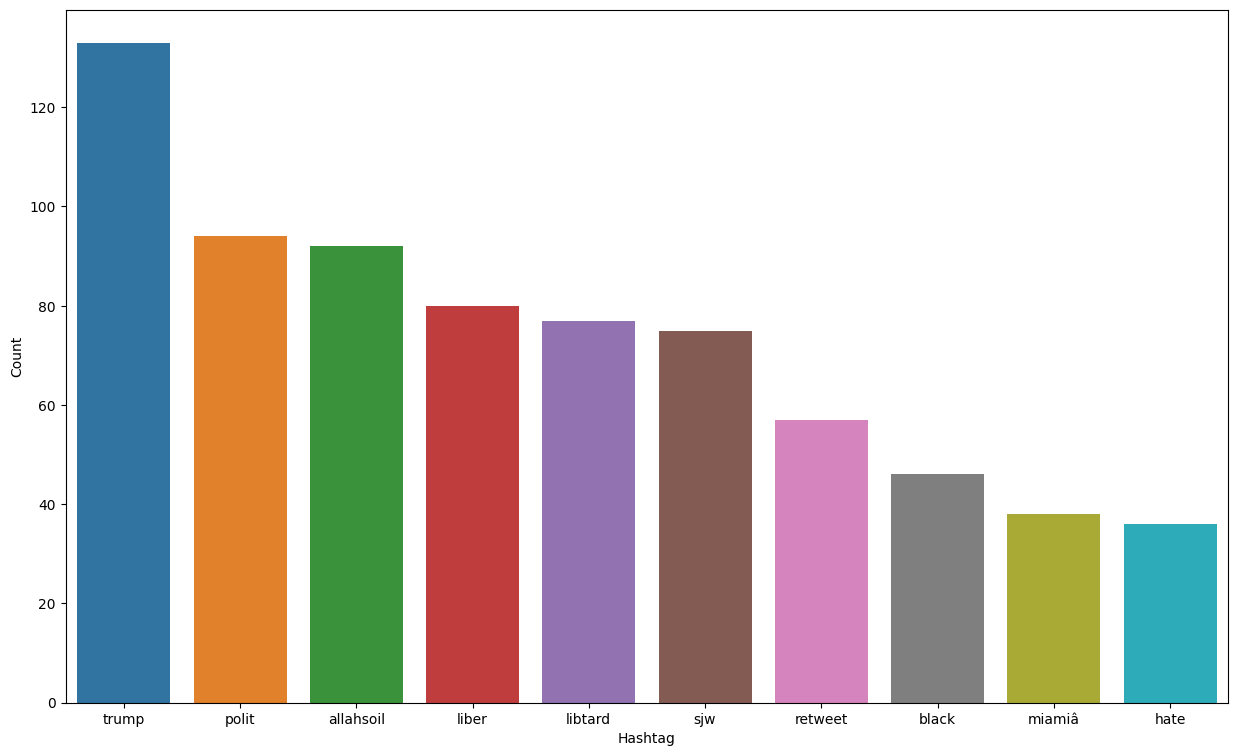

In [39]:
# Select top 10 hashtags
d = d.nlargest(columns = 'Count', n = 10)
plt.figure(figsize = (15,9))
sns.barplot(data = d, x = 'Hashtag', y = 'Count')

### Input Split

In [41]:
# Feature extraction
bow_vectorizer = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words = 'english')
bow = bow_vectorizer.fit_transform(df['clean_tweet'])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(bow, df['label'], test_size = 0.25, stratify = df['label'], random_state = 42)

## Model Training

In [52]:
# Choosing the best model using cross val 
# Define a dictionary of models
models =  {'logistic_regression' : LogisticRegression(), 'descion_tree' : DecisionTreeClassifier(), 'random_forest' : RandomForestClassifier(), 'XGBoost' : XGBClassifier()}
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for model_name, model in models.items():
    
    kf = KFold(n_splits = 6, random_state = 42, shuffle = True)
    y_pred = cross_val_predict(model, X_train, y_train, cv = kf)
    
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    
# Create a DataFrame to store the results
results_df = pd.DataFrame(results)

print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0  logistic_regression  0.947645   0.770305  0.361095  0.491697
1         descion_tree  0.918360   0.429807  0.502677  0.463395
2        random_forest  0.936465   0.552318  0.496133  0.522720
3              XGBoost  0.947895   0.794278  0.346817  0.482816


In [53]:
xgb = XGBClassifier()

In [55]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Evaluation

In [57]:
# Accuracy on train data
pred_training_data = xgb.predict(X_train)
accuracy_training_data = accuracy_score(pred_training_data, y_train)
accuracy_training_data

0.9531100079262442

In [59]:
# Accuracy on test data
pred_testing_data = xgb.predict(X_test)
accuracy_testing_data = accuracy_score(pred_testing_data, y_test)
accuracy_testing_data

0.9479414341133775

In [60]:
print(classification_report(y_test, pred_testing_data))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7430
           1       0.81      0.34      0.47       561

    accuracy                           0.95      7991
   macro avg       0.88      0.66      0.72      7991
weighted avg       0.94      0.95      0.94      7991

